In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

Обозначим некоторые константы:

In [2]:
batch_size_train = 64
batch_size_test = 1000
log_interval = 10
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Загрузим датасет:

In [3]:
train_data = torchvision.datasets.MNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, num_workers=4)

test_data = torchvision.datasets.MNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Посмотрим на датасет:

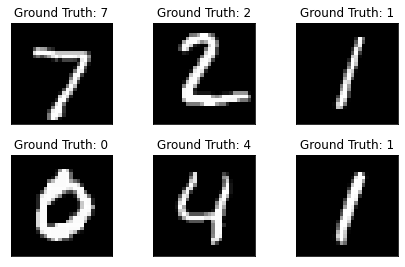

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

Теперь построим саму сеть:

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

И обучим её:

In [6]:
learning_rate = 0.001
n_epochs = 4

network = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

Самая мерзкая часть в pytorch - надо тренировку прописывать руками. Я не хочу думать, я хочу fit-predict!

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'models/model.pth')
            torch.save(optimizer.state_dict(), 'models/optimizer.pth')
            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    sim_error_matrix = [[None for __ in range(10)] for _ in range(10)]
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

И запустим обучение:

In [8]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3065, Accuracy: 1101/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296722
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.199549
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.143404
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.896700
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.529735
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.307591
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.051741
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.005192
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.198711
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.836510
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.642386
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.715449
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.643685
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.668523
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.572193
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.708503
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.817251
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.613615
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.053329
Train Epoch: 1 [12160

/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


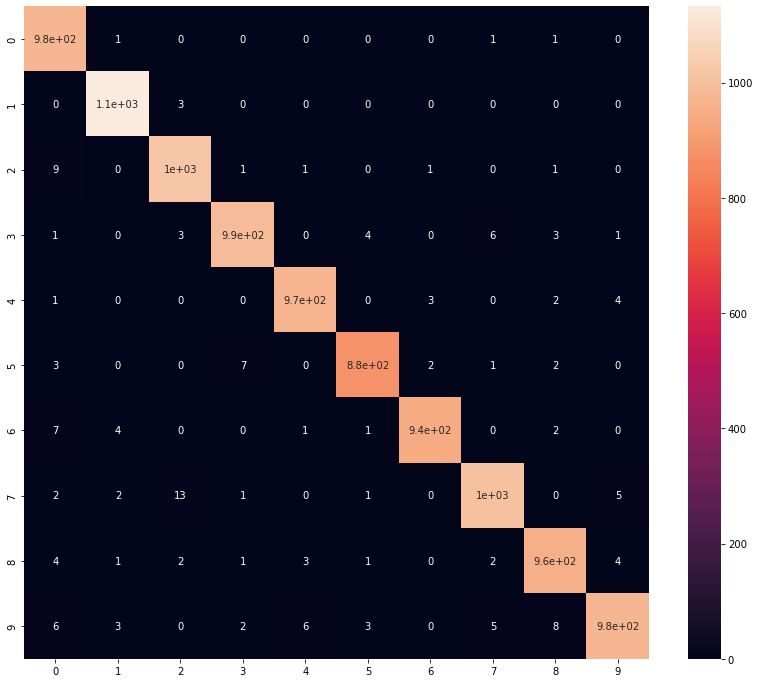

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []


for inputs, labels in test_loader:
    output = network(inputs)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (14, 12))
sns.heatmap(cf_matrix, annot=True)
plt.show()

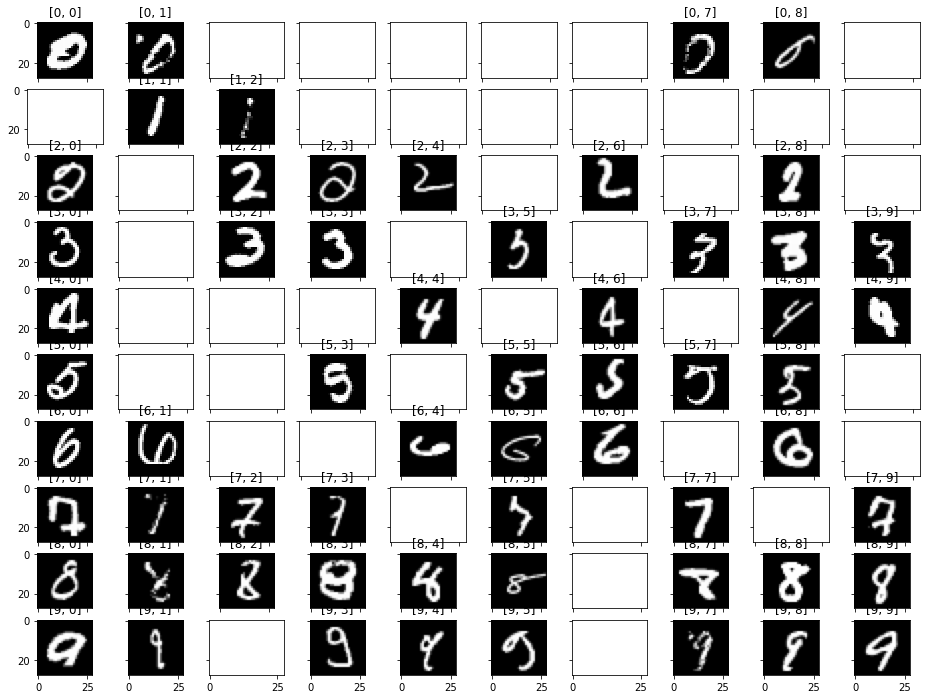

In [10]:
Xfig, axes = plt.subplots(10, 10, figsize=(16, 12), sharex=True, sharey=True)

sim_error_matrix = [[None for __ in range(10)] for _ in range(10)]

for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    sim_error_matrix[true][pred], _ = test_data[i]

for i in range(10):
    for j in range(10):
        if sim_error_matrix[i][j] is not None:
            axes[i][j].imshow(np.squeeze(sim_error_matrix[i][j]), cmap='gray')
            axes[i][j].set_title(label=f"[{i}, {j}]")
plt.show()

# Теперь Fashion MNIST

In [17]:
train_data = torchvision.datasets.FashionMNIST('data/fashion', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, num_workers=4)

test_data = torchvision.datasets.FashionMNIST('data/fashion', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, num_workers=4)

In [18]:
network = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [19]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3051, Accuracy: 1002/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286224
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.193750
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.042313
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.888489
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.562985
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.463880
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.344236
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.365148
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.169899
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.011710
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.299892
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.003093
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.148085
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.100638
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.207740
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.178254
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.941853
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.915615
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.253026
Train Epoch: 1 [12160

/home/covariance/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


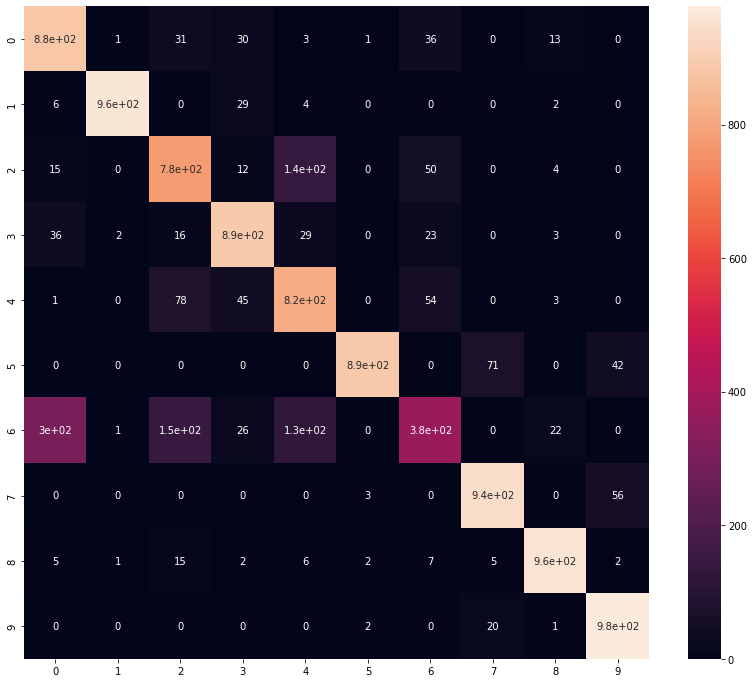

In [21]:
y_pred = []
y_true = []


for inputs, labels in test_loader:
    output = network(inputs)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (14, 12))
sns.heatmap(cf_matrix, annot=True)
plt.show()

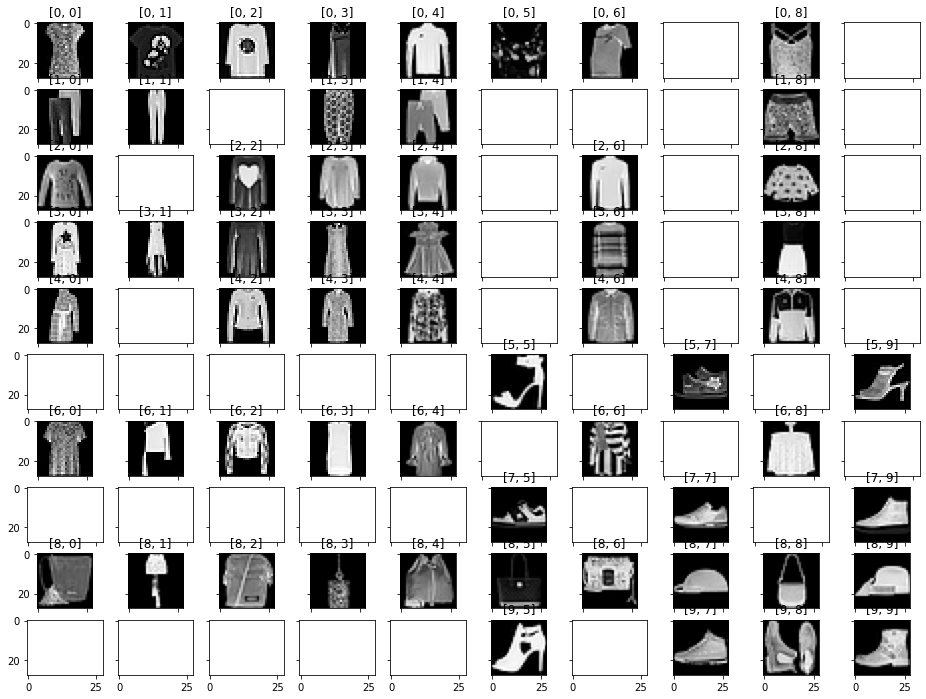

In [22]:
Xfig, axes = plt.subplots(10, 10, figsize=(16, 12), sharex=True, sharey=True)

sim_error_matrix = [[None for __ in range(10)] for _ in range(10)]

for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    sim_error_matrix[true][pred], _ = test_data[i]

for i in range(10):
    for j in range(10):
        if sim_error_matrix[i][j] is not None:
            axes[i][j].imshow(np.squeeze(sim_error_matrix[i][j]), cmap='gray')
            axes[i][j].set_title(label=f"[{i}, {j}]")
plt.show()